# Areal source models for Nath & Thingbaijam (2012)

Investigate and visualize models.

Note: For imports to work, ../utilities directory must be added to PYTHONPATH

_Copyright (C) 2014-2018 Nick Ackerley_

_This program is free software: you can redistribute it and/or modify
it under the terms of the GNU Affero General Public License as
published by the Free Software Foundation, either version 3 of the
License, or (at your option) any later version._

_This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the
GNU Affero General Public License for more details._

_You should have received a copy of the GNU Affero General Public 
License along with this program. If not, see 
<https://www.gnu.org/licenses/>._

In [1]:
import os
from time import time

import numpy as np
import pandas as pd
import geopandas as gpd

from IPython.display import display
import matplotlib.pyplot as plt

from shapely.geometry import Point
from obspy.imaging.beachball import beachball

from source_model_tools import csv2areal

pd.set_option('mode.chained_assignment', 'raise')

%matplotlib inline

In [2]:
MIN_MAGS = [4.5, 5.5]
LAYERS_DF = pd.read_csv('layers.csv', index_col='layerid')

# auxiliary information for comparison to model
AUX2_FILE = 'TRT_assignments_KKST.csv'
SIGNIFICANT_EVENTS_FILE = '../Data/nath2011peak/Table6.csv'
COMPLETENESS_FILE = '../Data/thingbaijam2011seismogenic/Table1.csv'
CATALOGUE_FILE = '../Catalogue/SACAT1900_2008v2.txt'

## Load areal zone description

In [3]:
areal_csv = 'areal_source_model.csv'
areal_df = csv2areal(areal_csv)

Reading:
	/home/nick/Desktop/indian-subcontinent-psha/Source Models/areal_source_model.csv


## Query a zone

In [4]:
print('\nA typical zone:')
print(areal_df.loc[172])


A typical zone:
layerid                                                               4
a                                                                  3.72
b                                                                  0.86
stdb                                                                0.1
mmax                                                                  8
stdmmax                                                             0.3
strike                                                               99
dip                                                                  64
rake                                                                -50
geometry              POLYGON ((94.34999999999999 1.99, 90.010000000...
aspect ratio                                                          2
msr                                                   StrasserIntraslab
tectonic zone                                      Subduction intraslab
region                                         

## Compare with information provided by Kiran Thingbaijam

In [5]:
print('\nReading: ' + os.path.abspath(AUX2_FILE))
aux2_df = pd.read_csv(AUX2_FILE, na_values=['nan'], keep_default_na=False)
aux2_df.set_index('zoneid', inplace=True, verify_integrity=True)
aux2_df.sort_index(inplace=True)
assert (areal_df.index == aux2_df.index).all()
assert (areal_df['layerid'] == aux2_df['layerid']).all()

areal2_df = areal_df.join(aux2_df, rsuffix='2', how='outer')
areal2_df.fillna('', inplace=True)

print('\nThese zones have identical focal mechanisms:')
duplicated_df = areal2_df[
    areal2_df.duplicated(['strike', 'dip', 'rake'], keep=False) &
    np.logical_not(pd.isnull(areal2_df['dip'])) &
    (areal2_df['mechanism'] != 'undefined')].copy()
duplicated_df.sort_values('dip', inplace=True)
display(duplicated_df[
    ['layerid', 'faulting style', 'new style',
     'strike', 'dip', 'rake', 'mechanism',
     'strike2', 'dip2', 'rake2', 'mechanism2']
])


Reading: /home/nick/Desktop/indian-subcontinent-psha/Source Models/TRT_assignments_KKST.csv

These zones have identical focal mechanisms:


,layerid,faulting style,new style,strike,dip,rake,mechanism,strike2,dip2,rake2,mechanism2
zoneid,,,,,,,,,,,
921,1,reverse,reverse,283,26,129,reverse,61.0,70.1,72.9,reverse
933,2,reverse,reverse,283,26,129,reverse,61.0,70.1,72.9,reverse
925,2,normal,normal,65,37,-26,sinistral,176.3,74.7,-124.1,normal
927,2,normal,normal,65,37,-26,sinistral,176.3,74.7,-124.1,normal
119,2,reverse,reverse,112,40,90,reverse,292.0,50.0,90.0,reverse
912,1,reverse,reverse,112,40,90,reverse,292.0,50.0,90.0,reverse
914,1,strike-slip,reverse,192,46,124,reverse,327.8,53.4,59.9,reverse
916,1,reverse,reverse,192,46,124,reverse,327.8,53.4,59.9,reverse
93,2,strike-slip,strike-slip,196,77,-2,sinistral,286.5,88.1,-167.0,sinistral


In [6]:
# bring terminologies in line for comparison

areal2_df['tectonic subregion'] = (
    areal2_df['tectonic subregion']
    .str.lower()
    .str.replace('himalayas', '')
    .str.replace('strike-slip reverse', '')
    .str.replace('normal', '')
    .str.strip()
)
areal2_df['tectonic zone'] = (
    areal2_df['tectonic zone']
    .str.lower()
)
areal2_df['mechanism'] = (
    areal2_df['mechanism']
    .replace('dextral', 'strike-slip')
    .replace('sinistral', 'strike-slip')
)
areal2_df['mechanism2'] = (
    areal2_df['mechanism2']
    .replace('dextral', 'strike-slip')
    .replace('sinistral', 'strike-slip')
)

different_mechanism_df = areal2_df[
    (areal2_df['mechanism'] != areal2_df['faulting style']) &
    (areal2_df['tectonic subregion'] != 'no seismicity') &
    (areal2_df['dip'].apply(np.isreal))
]
different_trt_df = areal2_df[
    (areal2_df['tectonic subregion'] !=
     areal2_df['tectonic region type']) &
    (areal2_df['tectonic subregion'] != 'no seismicity')
]

print('%d/%d (%d%%) mechanisms different' %
      (len(different_mechanism_df), len(areal_df),
       100*len(different_mechanism_df)/len(areal_df)))
print('%d/%d (%d%%) TRTs different' %
      (len(different_trt_df), len(areal_df),
       100*len(different_trt_df)/len(areal_df)))

14/104 (13%) mechanisms different
47/104 (45%) TRTs different


## Plot focal plane alternatives

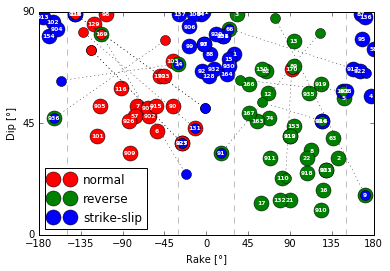

In [7]:
subset_df = areal2_df[
    areal2_df['dip'].apply(np.isreal) &
    (areal2_df['dip'] != -1) &
    (areal2_df['faulting style'] != '')]
wrong_df = different_mechanism_df[
    different_mechanism_df['dip'].apply(np.isreal) &
    (different_mechanism_df['dip'] != -1) &
    (different_mechanism_df['faulting style'] != '')]
colours = {
    'normal': 'red',
    'reverse': 'green',
    'strike-slip': 'blue'
}

fig, ax = plt.subplots()
ax.margins(0.05)  # Optional, just adds 5% padding to the autoscaling

for name, group in subset_df.groupby('faulting style'):
    ax.plot(group['rake'], group['dip'], color=colours[name],
            marker='o', markersize=15, linestyle='', linewidth=2,
            label=name)
    for x, y, zone_id in zip(group['rake'], group['dip'], group.index):
        ax.annotate(s=zone_id, xy=(x, y),
                    xytext=(0, 0), textcoords='offset points',
                    fontsize=6, fontweight='bold', color='white',
                    horizontalalignment='center',
                    verticalalignment='center')
for _, zone in wrong_df.iterrows():
    ax.plot([zone['rake'], zone['rake2']], [zone['dip'], zone['dip2']],
            linestyle=':', color='black', linewidth=0.5, label=None)
    ax.plot(zone['rake'], zone['dip'], color=colours[zone['mechanism']],
            marker='o', markersize=10, markeredgecolor='black',
            linestyle='', linewidth=2, label=None)
    ax.plot(zone['rake2'], zone['dip2'], color=colours[zone['mechanism2']],
            marker='o', markersize=10, markeredgecolor='black',
            linestyle='', linewidth=2, label=None)

ax.legend(loc='lower left')
for threshhold in [-150, -30, 30, 150]:
    ax.axvline(x=threshhold, linestyle='--', color='grey', linewidth=0.5)
ax.set_xlim((-180, 180))
ax.set_xlabel(('Rake [°]'))
ax.set_xticks(range(-180, 181, 45))
ax.set_ylim((0, 90))
ax.set_ylabel(('Dip [°]'))
ax.set_yticks(range(0, 91, 45))

fig.savefig('FocalMechanisms.png', transparent=True,
            bbox_inches='tight', pad_inches=0.1)


## Summarize discrepancies

In [9]:
print('\nZoes with wrong faulting style in the initial implementation')
display(wrong_df[
    ['layerid', 'faulting style', 'new style',
     'strike', 'dip', 'rake', 'mechanism',
     'strike2', 'dip2', 'rake2', 'mechanism2']])


print('\nZones with different tectonic region types')
display(different_trt_df[[
    'layerid', 'strike', 'dip', 'rake', 'a',
    'mechanism', 'faulting style',
    'tectonic zone', 'tectonic subregion', 'tectonic region type'
]])

print('\nZones with different faulting styles')
display(different_mechanism_df[[
    'layerid', 'strike', 'dip', 'rake',
    'mechanism', 'faulting style',
]])

print('\nZones assigned different faulting styles')

keep_columns = ['layerid', 'strike', 'dip', 'rake',
                'mechanism', 'mechanism2', 'faulting style', 'new style']
display(different_mechanism_df[
    different_mechanism_df['faulting style'] !=
    different_mechanism_df['new style']][keep_columns])

print('\nNon-zero b-values:')
print(areal_df[areal_df['stdb'] != 0]['stdb'].describe())

print('\nHighest and lowest activity rates')
drop_columns = ['tectonic zone', 'region', 'concerns', 'geometry',
                'aspect ratio', 'dip', 'rake', 'strike']
temp_df = areal_df[areal_df.a != 0].drop(drop_columns, axis=1).sort_values('a')
display(pd.concat([temp_df.head(), temp_df.tail()]))

print('\nZones without seismicity:')
areal_df[areal_df['tectonic subregion'] == 'no seismicity'].drop(
    drop_columns, axis=1)

print('\nTectonic subregions:', set(areal_df['tectonic subregion']))


Zoes with wrong faulting style in the initial implementation


,layerid,faulting style,new style,strike,dip,rake,mechanism,strike2,dip2,rake2,mechanism2
zoneid,,,,,,,,,,,
9,1,reverse,reverse,36,16,171,strike-slip,134.7,87.5,74.2,reverse
14,1,reverse,strike-slip,228,69,-30,strike-slip,329.7,62.2,-156.1,strike-slip
66,1,reverse,strike-slip,58,83,25,strike-slip,324.7,65.2,172.3,strike-slip
91,2,reverse,reverse,63,33,16,strike-slip,319.5,81.4,122.0,reverse
118,2,strike-slip,normal,301,89,-141,normal,210.2,51.0,-1.3,strike-slip
131,2,normal,normal,256,43,-12,strike-slip,354.8,81.8,-132.4,normal
162,3,strike-slip,reverse,176,58,147,reverse,285.0,62.5,36.7,reverse
169,4,reverse,normal,305,81,-113,normal,194.8,24.6,-22.1,strike-slip
170,4,normal,reverse,103,67,92,reverse,277.9,23.1,85.3,reverse



Zones with different tectonic region types


,layerid,strike,dip,rake,a,mechanism,faulting style,tectonic zone,tectonic subregion,tectonic region type
zoneid,,,,,,,,,,
1,1,202,73,30,5.20,strike-slip,strike-slip,subduction interface,subduction interface,active shallow crust
2,1,306,31,142,4.64,reverse,reverse,subduction interface,subduction interface,active shallow crust
4,1,309,56,177,4.34,strike-slip,strike-slip,subduction interface,subduction interface,active shallow crust
5,1,274,55,148,4.29,reverse,reverse,subduction interface,subduction interface,active shallow crust
13,1,138,78,94,3.24,reverse,reverse,subduction interface,subduction interface,active shallow crust
15,1,204,71,24,4.88,strike-slip,strike-slip,subduction interface,subduction interface,active shallow crust
16,1,298,18,126,4.36,reverse,reverse,subduction interface,subduction interface,active shallow crust
17,1,219,13,59,3.25,reverse,reverse,subduction interface,subduction interface,active shallow crust
87,2,150,89,166,5.97,strike-slip,strike-slip,subduction interface,subduction interface,



Zones with different faulting styles


,layerid,strike,dip,rake,mechanism,faulting style
zoneid,,,,,,
9,1,36,16,171,strike-slip,reverse
14,1,228,69,-30,strike-slip,reverse
66,1,58,83,25,strike-slip,reverse
91,2,63,33,16,strike-slip,reverse
118,2,301,89,-141,normal,strike-slip
131,2,256,43,-12,strike-slip,normal
162,3,176,58,147,reverse,strike-slip
169,4,305,81,-113,normal,reverse
170,4,103,67,92,reverse,normal



Zones assigned different faulting styles


,layerid,strike,dip,rake,mechanism,mechanism2,faulting style,new style
zoneid,,,,,,,,
14,1,228,69,-30,strike-slip,strike-slip,reverse,strike-slip
66,1,58,83,25,strike-slip,strike-slip,reverse,strike-slip
118,2,301,89,-141,normal,strike-slip,strike-slip,normal
162,3,176,58,147,reverse,reverse,strike-slip,reverse
169,4,305,81,-113,normal,strike-slip,reverse,normal
170,4,103,67,92,reverse,reverse,normal,reverse
914,1,192,46,124,reverse,reverse,strike-slip,reverse
928,2,301,89,-141,normal,strike-slip,strike-slip,normal
936,3,140,47,-164,strike-slip,normal,reverse,normal



Non-zero b-values:
count    99.000000
mean      0.095354
std       0.024839
min       0.030000
25%       0.080000
50%       0.100000
75%       0.115000
max       0.160000
Name: stdb, dtype: float64

Highest and lowest activity rates


,layerid,a,b,stdb,mmax,stdmmax,msr,tectonic subregion,zmin,zmax,mechanism,new style,strike2,dip2,rake2,mechanism2,mmin,centroid,source_name,id
zoneid,,,,,,,,,,,,,,,,,,,,
924,1,1.58,0.63,0.10,6.2,0.3,WC1994,stable shallow crust,0.0,25.0,undefined,undefined,270.0,90.0,89.0,reverse,4.5,POINT (83.90 19.63),zone 924,z924
923,1,2.51,0.73,0.06,6.0,0.3,WC1994,stable shallow crust,0.0,25.0,undefined,undefined,270.0,90.0,89.0,reverse,4.5,POINT (76.67 12.77),zone 923,z923
921,1,2.53,0.76,0.07,7.0,0.4,WC1994,stable shallow crust,0.0,25.0,reverse,reverse,61.0,70.1,72.9,reverse,4.5,POINT (79.77 22.50),zone 921,z921
74,1,2.57,0.86,0.07,6.5,0.3,WC1994,stable shallow crust,0.0,25.0,reverse,reverse,134.6,47.3,111.9,reverse,4.5,POINT (76.54 18.37),zone 74,z74
81,1,2.65,0.86,0.12,6.2,0.3,WC1994,stable shallow crust,0.0,25.0,undefined,undefined,270.0,90.0,89.0,reverse,4.5,POINT (80.47 15.48),zone 81,z81
116,2,6.23,1.30,0.12,7.0,0.2,StrasserInterface,subduction interface,25.0,70.0,normal,normal,30.9,31.1,-86.7,normal,4.5,POINT (94.76 31.82),zone 116,z116
154,3,6.37,1.28,0.09,7.3,0.3,StrasserIntraslab,subduction intraslab Himalayas,70.0,180.0,sinistral,strike-slip,8.1,79.2,-10.2,sinistral,4.5,POINT (74.09 38.23),zone 154,z154
57,1,6.79,1.35,0.10,7.2,0.4,WC1994,active shallow crust normal,0.0,25.0,normal,normal,45.0,43.6,-104.0,normal,4.5,POINT (95.16 11.67),zone 57,z57
909,1,7.08,1.37,0.12,7.6,0.3,WC1994,active shallow crust normal,0.0,25.0,normal,normal,78.5,57.4,-95.2,normal,4.5,POINT (92.94 32.23),zone 909,z909



Zones without seismicity:

Tectonic subregions: {'no seismicity', 'subduction intraslab Himalayas', 'active shallow crust normal', 'subduction interface', 'subduction intraslab', 'intraplate margin upper', 'active shallow crust strike-slip reverse', 'intraplate margin lower', 'stable shallow crust'}


## Histograms of FMD parameters

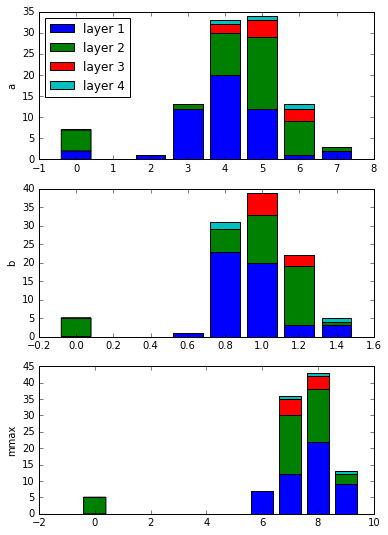

In [10]:
props = ['a', 'b', 'mmax']
ranges = [np.arange(-0.5, 8, 1),
          np.arange(-0.1, 1.7, 0.2),
          np.arange(-0.5, 10, 1)]
groups = areal_df.groupby('layerid')
fig, axes = plt.subplots(nrows=len(props), ncols=1,
                         figsize=(6, 3*len(props)))
for prop, ax, bins in zip(props, axes, ranges):
    data = [group[prop] for _, group in groups]
    labels = ['layer %d' % layer_id for layer_id, _ in groups]
    ax.hist(data, label=labels, stacked=True, bins=bins)
    ax.set_ylabel(prop)
axes[0].legend(loc='upper left')
fig.savefig('ArealModelFmds.png', dpi=300,
            transparent=True, bbox_inches='tight', pad_inches=0.1)

## Associate catalogue events wtih zones

In [11]:
print('\nReading catalogue: ' + os.path.abspath(CATALOGUE_FILE))
catalogue_df = pd.read_csv(CATALOGUE_FILE, sep='\t')

fig, ax = plt.subplots(figsize=(6, 6))
catalogue_df['SHOCK_TYPE'].value_counts().plot(kind='pie', ax=ax)
fig.savefig('ShockTypes.png', transparent=True, bbox_inches='tight',
            pad_inches=0.1)
plt.close(fig)  # uncomment to view


Reading catalogue: /home/nick/Desktop/indian-subcontinent-psha/Catalogue/SACAT1900_2008v2.txt


In [12]:
mark = time()
catalogue_df['geometry'] = [Point(lon, lat)
                            for lon, lat in zip(catalogue_df['LON'],
                                                catalogue_df['LAT'])]
layer_catalogue_gdfs = []
for layer_id, layer in LAYERS_DF.iterrows():
    layer_catalogue_gdf = gpd.GeoDataFrame(catalogue_df[
        (catalogue_df['DEPTH'] >= layer['zmin']) &
        (catalogue_df['DEPTH'] < layer['zmax'])], crs='WGS84')
    layer_areal_gdf = gpd.GeoDataFrame(
        areal_df[areal_df['layerid'] == layer_id].reset_index()
        [['geometry', 'zoneid', 'layerid']], crs='WGS84')
    layer_catalogue_gdfs.append(
        gpd.sjoin(layer_catalogue_gdf, layer_areal_gdf,
                  how='left', op='intersects'))
catalogue_df = pd.concat(layer_catalogue_gdfs).drop('geometry')
print('Associated %d events with %d zones (%.0f s)' %
      (len(catalogue_df), len(areal_df), time() - mark))
display(pd.concat((catalogue_df.head(), catalogue_df.tail())))

Associated 49404 events with 104 zones (4 s)


,YEAR,MONTH,DAY,HH,MM,SS,LAT,LON,DEPTH,DEPTH_ERR,...,MAG,MAG_ERR,MAG_MW,MAG_MW_ERR,SOURCE,SHOCK_TYPE,geometry,index_right,zoneid,layerid
39,1906,10,4,6,52,-1.00,37.2000,67.3000,20.0,-1.0,...,5.70,-1.0,5.8,-1.00,AB2003a,Mainshock,POINT (67.3 37.2),NaN,NaN,NaN
46,1907,10,21,4,23,36.00,38.7000,68.1000,24.0,-1.0,...,7.30,-1.0,7.2,-1.00,UL2006a,Mainshock,POINT (68.09999999999999 38.7),NaN,NaN,NaN
48,1907,10,24,5,10,-1.00,38.0000,68.8000,18.0,-1.0,...,5.20,-1.0,5.5,-1.00,AB2003a,Mainshock,POINT (68.8 38),0.0,1.0,1.0
74,1911,1,1,14,59,0.00,36.5000,66.0000,20.0,-1.0,...,6.47,-1.0,6.4,-1.00,AB2003a,Mainshock,POINT (66 36.5),NaN,NaN,NaN
96,1913,9,9,18,43,-1.00,37.1000,68.1000,18.0,-1.0,...,5.00,-1.0,5.4,-1.00,AB2003a,Mainshock,POINT (68.09999999999999 37.1),4.0,5.0,1.0
50295,2008,12,26,15,56,29.97,37.1880,72.0040,216.8,41.0,...,3.20,0.1,3.4,0.28,ISC,Mainshock,POINT (72.00399999999999 37.188),1.0,170.0,4.0
50297,2008,12,26,22,12,56.66,36.2475,70.3301,189.1,66.0,...,3.20,0.2,3.4,0.33,ISC,Mainshock,POINT (70.3301 36.2475),0.0,169.0,4.0
50317,2008,12,29,18,24,32.58,36.4481,71.0448,200.0,46.0,...,3.30,0.1,3.5,0.28,ISC,Aftershock,POINT (71.0448 36.4481),0.0,169.0,4.0
50319,2008,12,30,3,9,28.10,36.4556,70.9448,198.7,29.0,...,3.90,-1.0,4.6,0.19,ISC,Aftershock,POINT (70.9448 36.4556),0.0,169.0,4.0
50331,2008,12,31,20,48,35.71,36.2467,70.8264,197.0,44.0,...,3.30,0.1,3.5,0.28,ISC,Mainshock,POINT (70.82640000000001 36.2467),0.0,169.0,4.0


## Completeness tables

In [13]:
print('\nReading completeness: ' + os.path.abspath(COMPLETENESS_FILE))
completeness_df = pd.read_csv(COMPLETENESS_FILE,
                              header=[0, 1], index_col=[0, 1])
# completeness_df.reset_index(inplace=True)
completeness_df.columns = [' '.join(col).strip()
                           for col in completeness_df.columns.values]
display(completeness_df)


Reading completeness: /home/nick/Desktop/indian-subcontinent-psha/Data/thingbaijam2011seismogenic/Table1.csv


,,4 start,4 end,4.5 start,4.5 end,5.5 start,5.5 end
zmin,zmax,,,,,,
0,25,1994,2008,1964,2008,1903,2008
25,70,1990,2008,1964,2008,1902,2008
70,180,1996,2008,1964,2008,1914,2008
180,300,1984,2008,1970,2008,1912,2008


## Compute areal zone activity rates from catalogue

In [14]:
catalogue_activity_df = pd.DataFrame()
for layer_id, layer in LAYERS_DF.join(completeness_df,
                                      on=['zmin', 'zmax']).iterrows():
    layer_results = pd.Series()
    for mag in reversed(MIN_MAGS):
        above_thresh = catalogue_df['MAG_MW'] >= mag
        start = layer[str(mag) + ' start']
        end = layer[str(mag) + ' end']
        at_depth = ((catalogue_df['DEPTH'] >= layer['zmin']) &
                    (catalogue_df['DEPTH'] < layer['zmax']))
        in_years = ((catalogue_df['YEAR'] >= start) &
                    (catalogue_df['YEAR'] <= end))
        in_a_zone = catalogue_df['zoneid'] != -1
        is_mainshock = catalogue_df['SHOCK_TYPE'] == 'Mainshock'
        subcat_df = catalogue_df[
            above_thresh & at_depth & in_years & in_a_zone & is_mainshock]
        layer_results = layer_results.append(pd.Series({
            'catalogue ' + str(mag):
                round(float(len(subcat_df))/(end - start + 1), 1),
            }, name=layer_id))
    catalogue_activity_df = catalogue_activity_df.append(layer_results,
                                                         ignore_index=True)
catalogue_activity_df = catalogue_activity_df.append(pd.Series(
    catalogue_activity_df.sum(axis=0), name='Total'))
display(catalogue_activity_df)

,catalogue 4.5,catalogue 5.5
0,87.9,5.1
1,98.1,4.9
2,44.3,1.8
3,11.6,1.3
Total,241.9,13.1


# Generate SVG beachballs for display in QGIS

In [15]:
bb_dir = './beachballs/'
print('\nGenerating SVG beachballs for areal zones:\n\t' +
      os.path.abspath(bb_dir))

mark = time()

if not os.path.isdir(bb_dir):
    os.mkdir(bb_dir)

for zoneid, zone in areal_df.iterrows():
    focal_mechanism = (zone['strike'], zone['dip'], zone['rake'])
    file_name = os.path.join(bb_dir, str(zoneid) + '.svg')
    beachball(focal_mechanism, outfile=file_name, facecolor='black')
    plt.close()
print('Wrote %d beachballs (%.0f s)' % (len(areal_df), time() - mark))

print('Reading significant events: ' +
      os.path.abspath(SIGNIFICANT_EVENTS_FILE))
df_events = pd.read_csv(SIGNIFICANT_EVENTS_FILE,
                        parse_dates=['Date'], na_values='-')
df_events.sort_values('H (km)', ascending=True, inplace=True)
print('Deep events:')
display(df_events[(df_events['H (km)'] >= 180) & (df_events['H (km)'] < 600)])

bb_dir = '../Data/nath2011peak/'
print('Generating SVG beachballs for significant events '
      'for display in QGIS:\n\t' + os.path.abspath(bb_dir))

mark = time()

if not os.path.isdir(bb_dir):
    os.mkdir(bb_dir)
for _, event in df_events.iterrows():
    focal_mechanism = (event['φ'], event['δ'], event['Λ'])
    file_name = os.path.join(
        bb_dir, str(event['Date'].date()).replace('-', '') + '.svg')
    beachball(focal_mechanism, outfile=file_name, facecolor='blue')
    plt.close()
print('Wrote %d beachballs (%.0f s)' % (len(df_events), time() - mark))


Generating SVG beachballs for areal zones:
	/home/nick/Desktop/indian-subcontinent-psha/Source Models/beachballs
Wrote 104 beachballs (5 s)
Reading significant events: /home/nick/Desktop/indian-subcontinent-psha/Data/nath2011peak/Table6.csv
Deep events:


,Date,M ($M_W$),Lat (°N),Lon (°E),φ,δ,Λ,H (km),FT,RL (km),RW (km),P,N,Ref
28,2005-12-12,6.5,36.45,71.06,279.0,40.0,106.0,210.2,R,20.0,18.0,D,7,7.0
23,2002-03-03,7.3,36.57,70.42,282.0,22.0,85.0,228.5,R,57.0,35.0,D,8,7.0


Generating SVG beachballs for significant events for display in QGIS:
	/home/nick/Desktop/indian-subcontinent-psha/Data/nath2011peak
Wrote 38 beachballs (2 s)
